**Q-Learning on Frozen Lake Environment**

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 14.4 MB/s eta 0:00:00


Action size: 4
State size: 25
Map size: 4x4


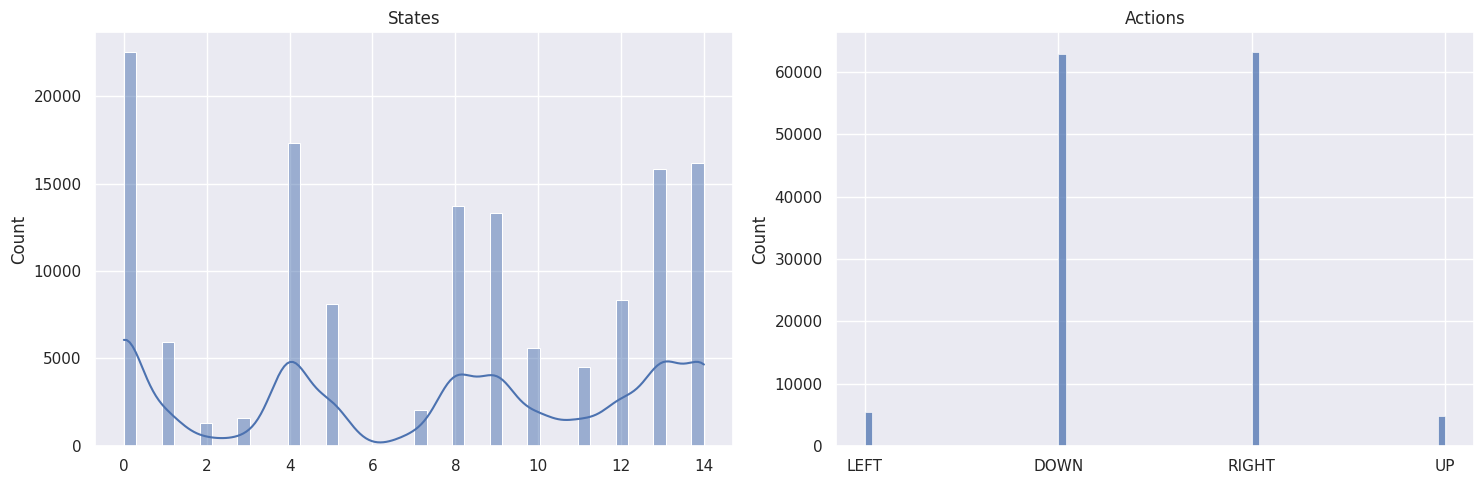

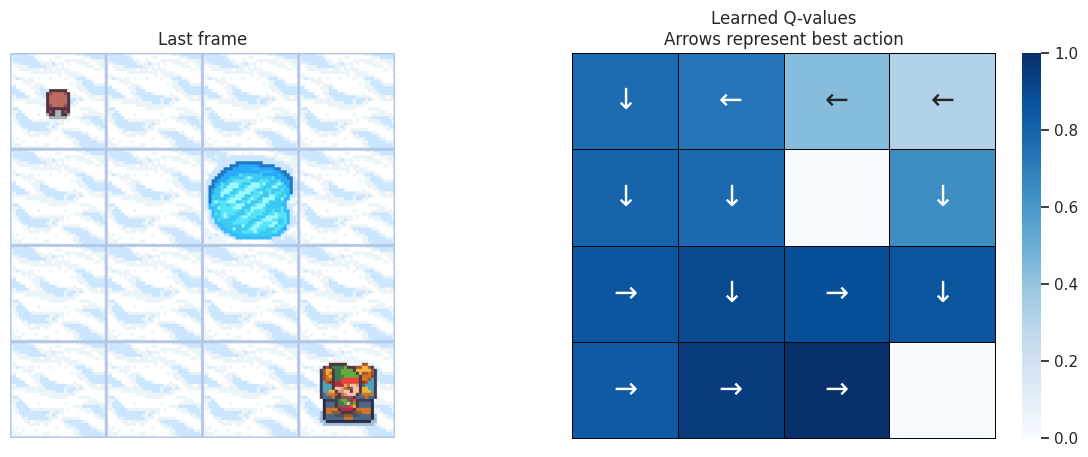

Map size: 7x7


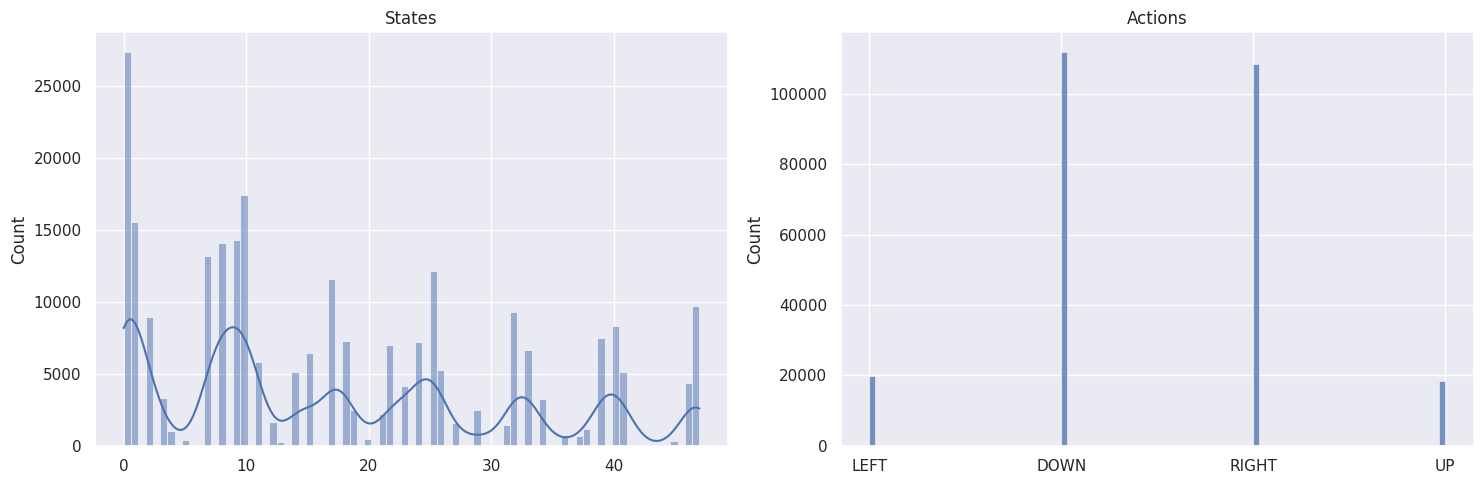

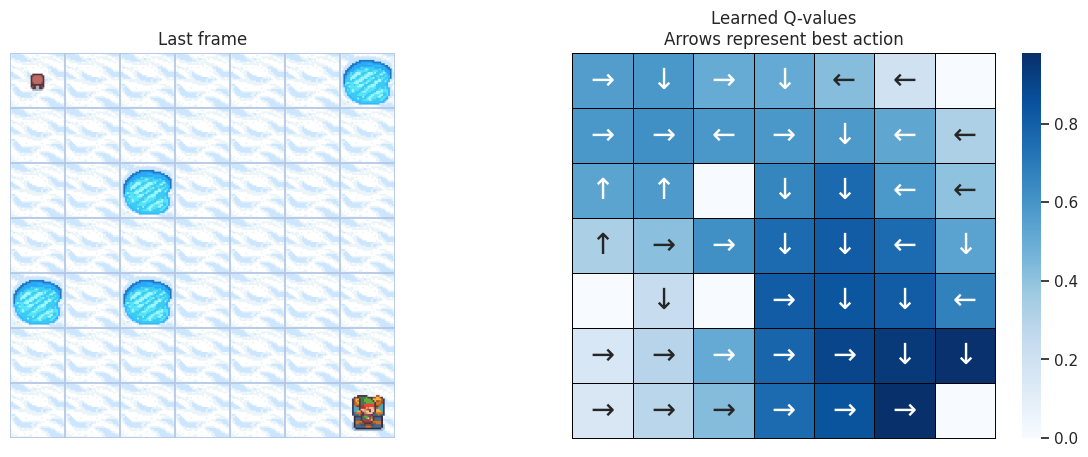

Map size: 9x9


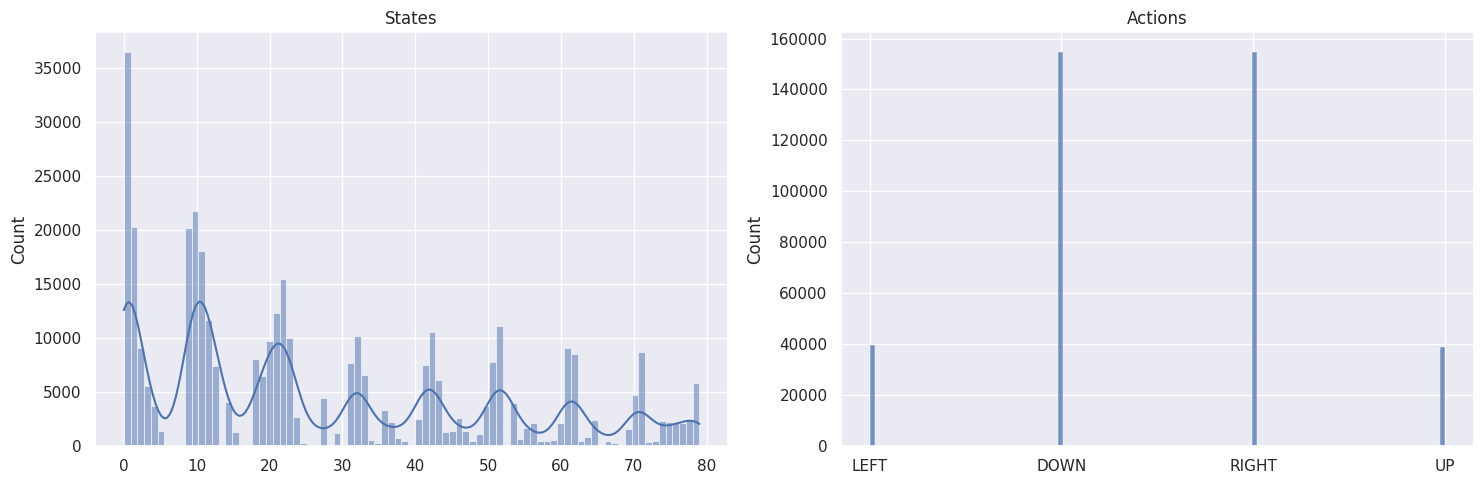

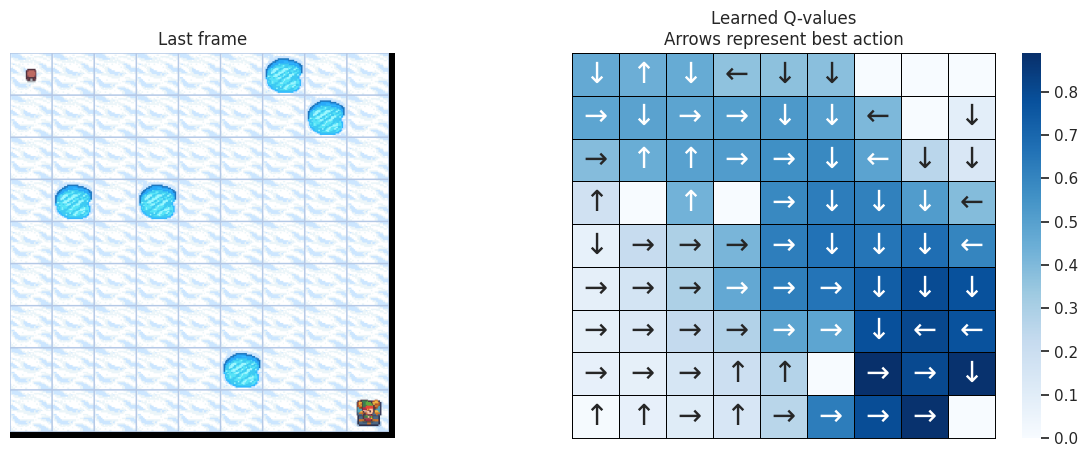

Map size: 11x11


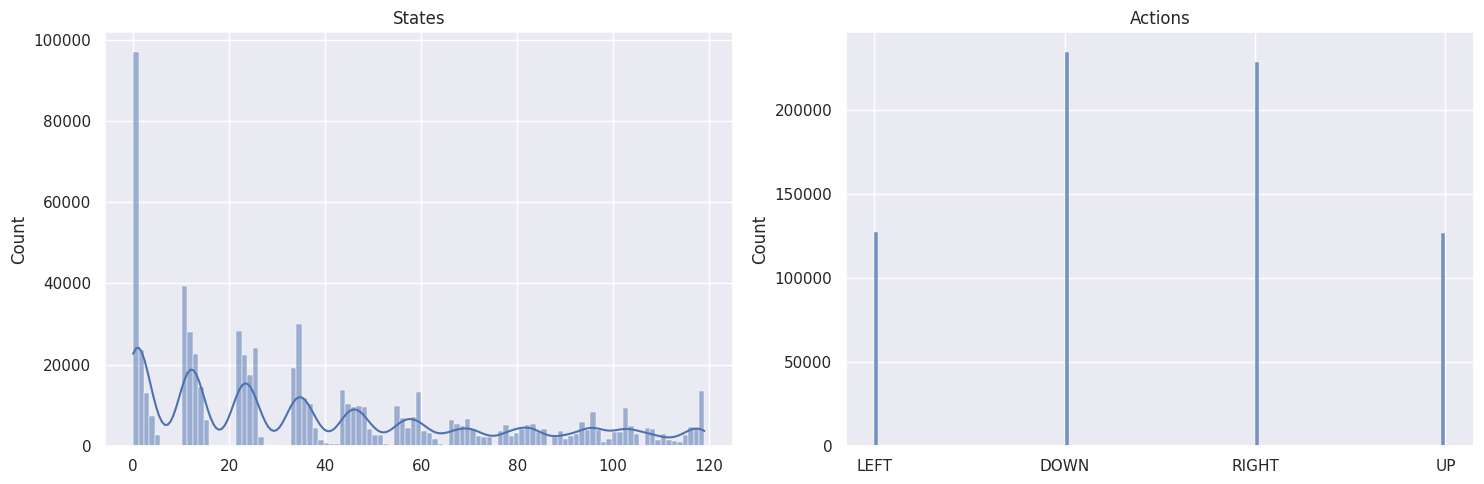

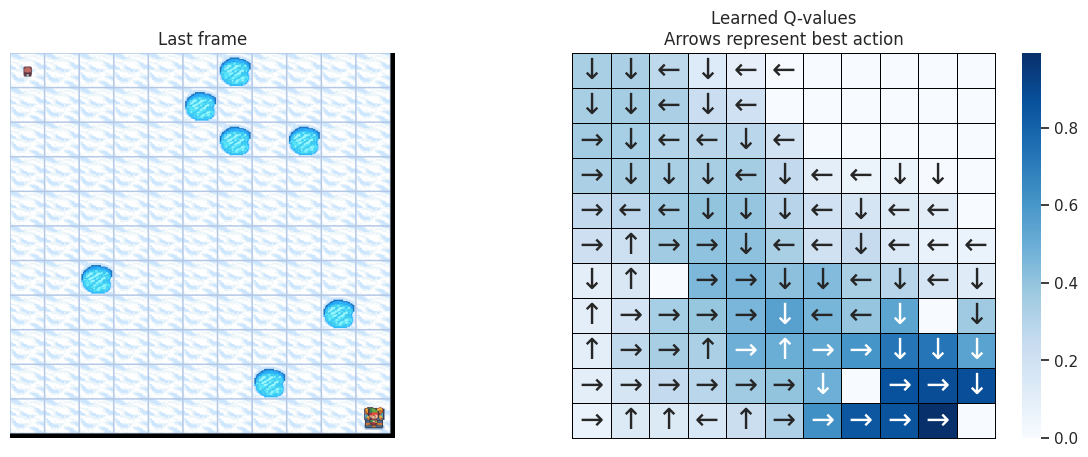

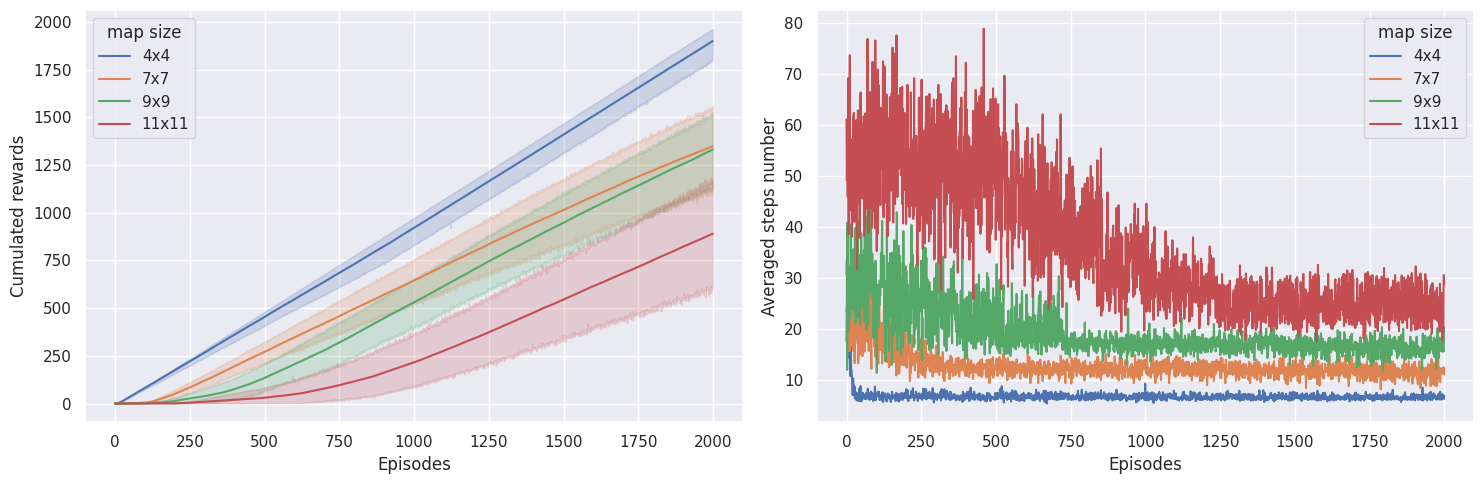

In [3]:
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

# Define parameters using NamedTuple
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved

# Parameters instantiation
params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=10,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)

# Create environment
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

# Update parameters with action and state sizes based on the environment
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)

# Print action and state sizes
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")

# Q-learning class
class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


# Epsilon-greedy class
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action a in the current world state (s)."""
        explor_exploit_tradeoff = rng.uniform(0, 1)  # Randomize a number
        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()
        # Exploitation
        else:
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()  # Break ties randomly
            else:
                action = np.argmax(qtable[state, :])
        return action

# Function to run environment
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):
        learner.reset_qtable()  # Reset Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                all_states.append(state)
                all_actions.append(action)

                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1
                state = new_state

            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

# Function to convert simulation results into dataframes
def postprocess(episodes, params, rewards, steps, map_size):
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

# Function to get the best learned action and map it to arrows
def qtable_directions_map(qtable, map_size):
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

# Function to plot the Q-values map
def plot_q_values_map(qtable, env, map_size):
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

# Function to plot the distribution of states and actions
def plot_states_actions_distribution(states, actions, map_size):
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

# Main loop for different map sizes
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(params.seed)
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )
    plot_q_values_map(qtable, env, map_size)

    env.close()

# Function to plot steps and rewards
def plot_steps_and_rewards(rewards_df, steps_df):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

plot_steps_and_rewards(res_all, st_all)

**Policy iteration algorithm**

In [6]:
import numpy as np
import gym

def evaluate_policy(environment, policy, discount_rate=0.95, num_episodes=100):
    """Evaluate the given policy by running it in the environment."""
    total_rewards = []
    for _ in range(num_episodes):
        # The reset() method now returns a tuple (obs, info) or just obs in newer versions
        # Here we handle both cases for compatibility
        reset_result = environment.reset()
        if isinstance(reset_result, tuple):
            state, _ = reset_result
        else:
            state = reset_result

        episode_reward = 0
        done = False
        while not done:
            action = policy[state]
            next_state, reward, done, _, = environment.step(action)
            episode_reward += reward
            if done:
                break
            state = next_state
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

def policy_iteration(environment, discount_rate=0.95, max_iterations=1000, threshold=1e-4):
    """Perform Policy Iteration to find the optimal policy."""
    num_states = environment.observation_space.n
    num_actions = environment.action_space.n

    # Initialize a random policy
    policy = np.random.choice(num_actions, size=num_states)

    for iteration in range(max_iterations):
        # Policy evaluation
        V = np.zeros(num_states)
        while True:
            delta = 0
            V_prev = V.copy()
            for state in range(num_states):
                action = policy[state]
                value = 0
                for prob, next_state, reward, _ in environment.P[state][action]:
                    value += prob * (reward + discount_rate * V_prev[next_state])
                V[state] = value
                delta = max(delta, abs(V[state] - V_prev[state]))
            if delta < threshold:
                break

        # Policy improvement
        policy_stable = True
        for state in range(num_states):
            old_action = policy[state]
            action_values = np.zeros(num_actions)
            for action in range(num_actions):
                for prob, next_state, reward, _ in environment.P[state][action]:
                    action_values[action] += prob * (reward + discount_rate * V[next_state])
            best_action = np.argmax(action_values)
            policy[state] = best_action
            if old_action != best_action:
                policy_stable = False

        if policy_stable:
            print(f"Policy converged after {iteration + 1} iterations.")
            break

    return policy, V

# Initialize FrozenLake environment
frozen_lake_env = gym.make("FrozenLake-v1", is_slippery=False)

# Apply Policy Iteration
optimal_policy, optimal_values = policy_iteration(frozen_lake_env)

# Display optimal policy in grid form
print("Optimal Policy (Policy Iteration):")
try:
    print(optimal_policy.reshape(frozen_lake_env.desc.shape))
except AttributeError:
    print(optimal_policy)  # For non-grid environments

# Evaluate the optimal policy
average_reward = evaluate_policy(frozen_lake_env, optimal_policy)
print(f"Average reward per episode with optimal policy (Policy Iteration): {average_reward:.2f}")


Policy converged after 7 iterations.
Optimal Policy (Policy Iteration):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]
Average reward per episode with optimal policy (Policy Iteration): 1.00


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


**Policy iteration to compare with Q-Learning**

In [12]:
import numpy as np
import gym

class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.qtable = np.zeros((state_size, action_size))  # Initialize Q-table

    def reset_qtable(self):
        self.qtable = np.zeros((self.state_size, self.action_size))  # Reset Q-table

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        self.qtable[state, action] += self.learning_rate * delta

    def train(self, environment, epsilon=1.0, min_epsilon=0.1, epsilon_decay=0.995, episodes=20000):
      """Train the agent using Q-Learning with epsilon decay."""
      for episode in range(episodes):
        # Reset environment and handle both older and newer gym APIs
        reset_result = environment.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        done = False
        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.choice(self.action_size)  # Explore
            else:
                action = np.argmax(self.qtable[state])  # Exploit

            # Take action and observe result
            step_result = environment.step(action)
            if len(step_result) == 4:
                # Newer gym versions return (next_state, reward, done, truncated, info)
                next_state, reward, done, _ = step_result[:4]
            else:
                # Older gym versions return (next_state, reward, done, info)
                next_state, reward, done, _ = step_result

            # Update Q-value
            self.qtable[state, action] = self.update(state, action, reward, next_state)
            state = next_state

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

      # Derive policy from Q-table
      policy = np.argmax(self.qtable, axis=1)
      return policy



# FrozenLake environment
env = gym.make("FrozenLake-v1", is_slippery=False)
state_size = env.observation_space.n
action_size = env.action_space.n

# Policy Iteration
optimal_policy_pi, _ = policy_iteration(env)
average_reward_pi = evaluate_policy(env, optimal_policy_pi)
print("Policy Iteration Results:")
print(f"Optimal Policy: {optimal_policy_pi}")
print(f"Average Reward (Policy Iteration): {average_reward_pi:.2f}")

# Q-Learning
q_agent = Qlearning(learning_rate=0.1, gamma=0.95, state_size=state_size, action_size=action_size)
optimal_policy_qlearning = q_agent.train(env, epsilon=0.1, episodes=10000)
average_reward_qlearning = evaluate_policy(env, optimal_policy_qlearning)
print("\nQ-Learning Results:")
print(f"Optimal Policy: {optimal_policy_qlearning}")
print(f"Average Reward (Q-Learning): {average_reward_qlearning:.2f}")

# Display the results
try:
    print("\nPolicy Iteration Grid:")
    print(optimal_policy_pi.reshape(env.desc.shape))
    print("\nQ-Learning Grid:")
    print(optimal_policy_qlearning.reshape(env.desc.shape))
except AttributeError:
    print("\nNon-grid environment. Displaying policy as lists:")
    print(f"Policy Iteration: {optimal_policy_pi}")
    print(f"Q-Learning: {optimal_policy_qlearning}")


Policy converged after 7 iterations.
Policy Iteration Results:
Optimal Policy: [1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]
Average Reward (Policy Iteration): 1.00

Q-Learning Results:
Optimal Policy: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Average Reward (Q-Learning): 0.00

Policy Iteration Grid:
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]

Q-Learning Grid:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


**Improved policy Iteration on Q-Learning to get better rewads**

In [14]:
import numpy as np
import gym

# Q-learning class
class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def reset_qtable(self):
        """Initialize Q-table to zeros."""
        self.qtable = np.zeros((self.state_size, self.action_size))

    def update(self, state, action, reward, next_state):
        """Q(s,a) := Q(s,a) + lr * [reward + gamma * max(Q(s',a')) - Q(s,a)]"""
        max_next_q = np.max(self.qtable[next_state])  # Max Q-value for the next state
        delta = reward + self.gamma * max_next_q - self.qtable[state, action]
        self.qtable[state, action] += self.learning_rate * delta

    def train(self, environment, epsilon=1.0, min_epsilon=0.1, epsilon_decay=0.995, episodes=20000):
        """Train the agent using Q-Learning."""
        for episode in range(episodes):
            # Reset environment and get initial state
            state = environment.reset()[0] if isinstance(environment.reset(), tuple) else environment.reset()

            done = False
            while not done:
                # Epsilon-greedy action selection
                if np.random.random() < epsilon:
                    action = environment.action_space.sample()  # Explore
                else:
                    action = np.argmax(self.qtable[state])  # Exploit

                # Take action in the environment
                next_state, reward, done, _ = environment.step(action)

                # Update Q-value
                self.update(state, action, reward, next_state)
                state = next_state

            # Decay epsilon
            epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Derive policy from Q-table
        policy = np.argmax(self.qtable, axis=1)
        return policy

def evaluate_policy(env, policy, episodes=100):
    """Evaluate a given policy by running it in the environment."""
    total_reward = 0
    for _ in range(episodes):
        state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
        done = False
        while not done:
            action = policy[state]
            state, reward, done, _ = env.step(action)
            total_reward += reward
    return total_reward / episodes

# Initialize FrozenLake environment
env = gym.make("FrozenLake-v1", is_slippery=False)  # Disable slippery for determinism

# Q-learning parameters
state_size = env.observation_space.n
action_size = env.action_space.n
learning_rate = 0.1
gamma = 0.95

# Initialize and train the Q-learning agent
q_agent = Qlearning(learning_rate=learning_rate, gamma=gamma, state_size=state_size, action_size=action_size)
optimal_policy_qlearning = q_agent.train(env, epsilon=1.0, episodes=20000)

# Evaluate and compare performance
average_reward_qlearning = evaluate_policy(env, optimal_policy_qlearning)

# Display Results
print("\nQ-Learning Results:")
print(f"Optimal Policy: {optimal_policy_qlearning}")
print(f"Average Reward (Q-Learning): {average_reward_qlearning:.2f}")
print("\nQ-Learning Grid:")
print(optimal_policy_qlearning.reshape(4, 4))  # Adjust for grid environments



Q-Learning Results:
Optimal Policy: [1 0 0 0 1 0 0 0 2 1 0 0 0 2 2 0]
Average Reward (Q-Learning): 1.00

Q-Learning Grid:
[[1 0 0 0]
 [1 0 0 0]
 [2 1 0 0]
 [0 2 2 0]]


**ATari Game Environment**

In [21]:
!pip install gym[atari]
!pip install gym==0.25.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00


In [22]:
!pip install gym[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=de4228ac0f0badac94639a6bd4ddc8e0af3f323daa9d47e365a91b2933af69b4
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [23]:
import gym

for env_spec in gym.envs.registry.values():
    print(env_spec.id)


CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v2
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
Reacher-v2
Reacher-v4
Pusher-v2
Pusher-v4
InvertedPendulum-v2
InvertedPendulum-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Walker2d-v2
Walker2d-v3
Walker2d-v4
Ant-v2
Ant-v3
Ant-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4


**Q-Learning on Taxi-v3**

In [35]:
import gym
import numpy as np

class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def reset_qtable(self):
        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.state_size, self.action_size))

    def choose_action(self, state, epsilon):
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def update_q_value(self, state, action, reward, next_state):
        future_q = np.max(self.q_table[next_state])
        # Q-learning update rule
        self.q_table[state, action] = self.q_table[state, action] + \
                                      self.learning_rate * (reward + self.gamma * future_q - self.q_table[state, action])

# Initialize the environment
env = gym.make('Taxi-v3')
n_states = env.observation_space.n
n_actions = env.action_space.n

# Q-learning hyperparameters
learning_rate = 0.1
gamma = 0.99
epsilon = 0.1
num_episodes = 1000

# Instantiate the Q-learning class
q_agent = Qlearning(learning_rate, gamma, n_states, n_actions)

# Training loop for Q-learning
for episode in range(num_episodes):
    state = env.reset()
    done = False

    while not done:
        action = q_agent.choose_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        q_agent.update_q_value(state, action, reward, next_state)

        state = next_state

# Evaluation loop without exploration
num_eval_episodes = 100
total_eval_reward = 0

for episode in range(num_eval_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = np.argmax(q_agent.q_table[state])  # Greedy policy
        state, reward, done, _ = env.step(action)
        episode_reward += reward

    total_eval_reward += episode_reward

# Print only the evaluation results
print(f"Average reward over {num_eval_episodes} evaluation episodes: {total_eval_reward / num_eval_episodes}")


Average reward over 100 evaluation episodes: -157.86


Q Table visualisation

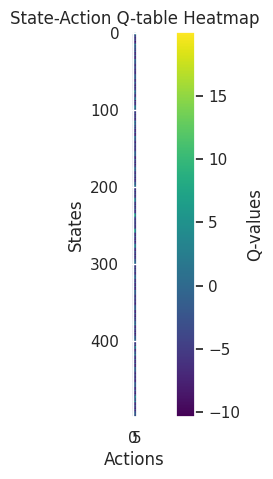

In [36]:
import matplotlib.pyplot as plt

# Plot Q-values as a heatmap
plt.figure(figsize=(10, 5))
plt.title("State-Action Q-table Heatmap")
plt.imshow(q_agent.q_table, cmap="viridis")
plt.colorbar(label="Q-values")
plt.xlabel("Actions")
plt.ylabel("States")
plt.show()


Number of Actions Taken

In [38]:
num_steps = 0

state = env.reset()
done = False

while not done:
    action = q_agent.choose_action(state, epsilon)
    state, reward, done, _ = env.step(action)
    num_steps += 1

print(f"Number of steps taken in an episode: {num_steps}")


Number of steps taken in an episode: 200


**Q-Learning code to an Atari game environment - Cartpole-v1**

100%|██████████| 2000/2000 [00:03<00:00, 532.13it/s]


Average Reward per Episode: 9.9055
Average Episode Length: 9.9055
Success Rate: 0.0%


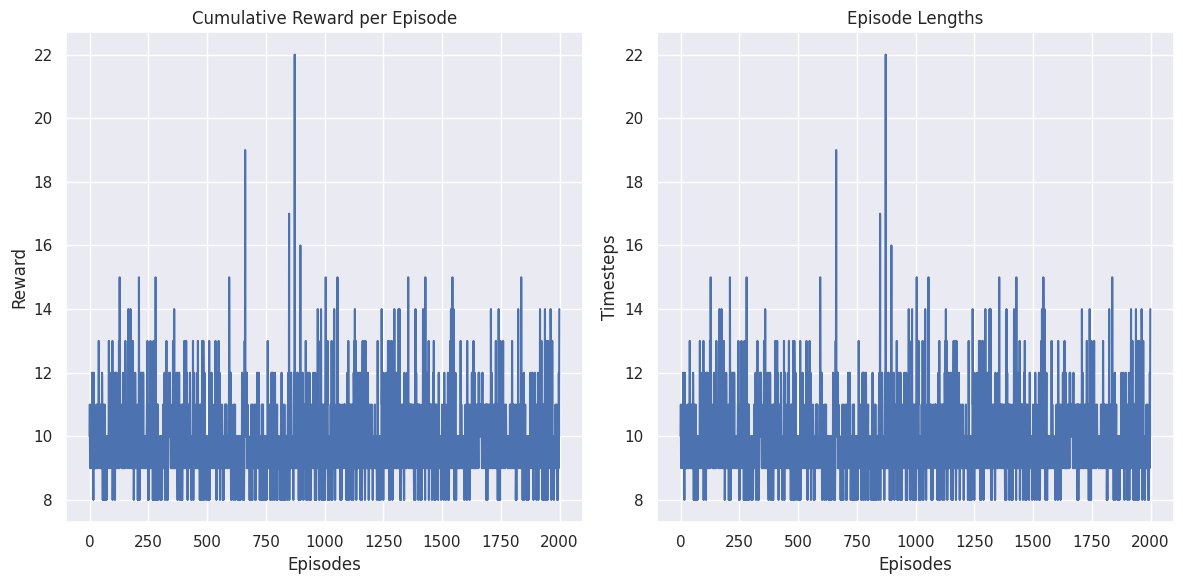

In [46]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from typing import NamedTuple, List

# Hyperparameters
class Params(NamedTuple):
    total_episodes: int
    learning_rate: float
    gamma: float
    epsilon: float
    n_runs: int
    savefig_folder: Path

params = Params(
    total_episodes=2000,
    learning_rate=0.1,
    gamma=0.99,
    epsilon=0.1,
    n_runs=5,
    savefig_folder=Path("./cartpole_figures/")
)

params.savefig_folder.mkdir(parents=True, exist_ok=True)

# Discretization function for continuous states
def discretize_state(state):
    state_bins = [
        np.linspace(-2.4, 2.4, 10),   # Cart position
        np.linspace(-2.0, 2.0, 10),   # Cart velocity
        np.linspace(-0.2, 0.2, 10),   # Pole angle
        np.linspace(-3.5, 3.5, 10)   # Pole angular velocity
    ]

    discretized_state = tuple(
        np.digitize(state[i], state_bins[i]) for i in range(4)
    )

    # Combine the discretized state into a single unique index
    new_state = sum([s * 10**i for i, s in enumerate(discretized_state)])

    # Use modulo to ensure it fits within 10000 states
    return new_state % 10000


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((10000, 4))  # 10000 states for discretized states, 4 actions

class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state):
        if np.random.rand() < self.epsilon:
            return action_space.sample()
        else:
            return np.argmax(learner.qtable[state])

def run_cartpole(params):
    total_rewards = np.zeros(params.total_episodes)
    episode_lengths = np.zeros(params.total_episodes)
    success_counts = 0

    env = gym.make('CartPole-v1')
    learner = Qlearning(params.learning_rate, params.gamma, 10000, 2)
    explorer = EpsilonGreedy(params.epsilon)

    for episode in tqdm(range(params.total_episodes)):
        state = discretize_state(env.reset())
        episode_reward = 0
        episode_length = 0
        done = False

        while not done:
            action = explorer.choose_action(env.action_space, state)

            next_state, reward, done, _ = env.step(action)
            next_state = discretize_state(next_state)

            updated_q_value = learner.update(state, action, reward, next_state)
            learner.qtable[state, action] = updated_q_value

            state = next_state
            episode_reward += reward
            episode_length += 1

        total_rewards[episode] = episode_reward
        episode_lengths[episode] = episode_length

        if episode_reward >= 195:
            success_counts += 1

    avg_reward = np.mean(total_rewards)
    avg_episode_length = np.mean(episode_lengths)
    success_rate = (success_counts / params.total_episodes) * 100

    print(f"Average Reward per Episode: {avg_reward}")
    print(f"Average Episode Length: {avg_episode_length}")
    print(f"Success Rate: {success_rate}%")

    return {
        'total_rewards': total_rewards,
        'episode_lengths': episode_lengths,
        'success_rate': success_rate
    }


def plot_metrics(metrics):
    plt.figure(figsize=(12, 6))

    # Plot reward per episode
    plt.subplot(1, 2, 1)
    plt.plot(metrics['total_rewards'])
    plt.title('Cumulative Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')

    # Plot episode lengths
    plt.subplot(1, 2, 2)
    plt.plot(metrics['episode_lengths'])
    plt.title('Episode Lengths')
    plt.xlabel('Episodes')
    plt.ylabel('Timesteps')

    plt.tight_layout()
    plt.show()

# Run and visualize
metrics = run_cartpole(params)
plot_metrics(metrics)

